# **Importando as Bibliotecas**

In [ ]:
!pip install python-binance
!pip install ta
!python --version
!pip install autots -qq

In [ ]:
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import datetime
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import json
import requests
import numpy as np
import pandas as pd
from ta import add_all_ta_features
from ta.utils import dropna
import matplotlib.patches as mpatches
from autots import AutoTS
from fbprophet.plot import plot
from sklearn.metrics import r2_score
from fbprophet import Prophet

# **1) Aquisição dos Dados**

* **Aquisição do histórico do Bitcoin e da Dogecoin pela API da Binance**

* **Conversão dos dados em UNIX para Datetime**


### **Acessando a API da Binance**

In [ ]:
api_key = #insert_binance_api_key
api_secret = #insert_binance_api_secret
client = Client(api_key, api_secret)

### **Convertendo UNIX para a medida de horário padrão**

In [ ]:
def unix_to_datetime(unix_time):
    return datetime.datetime.fromtimestamp(unix_time/1000.0)

def date_to_unix(date):
    date = datetime.datetime.now()
    date = date.replace(hour=0, minute=0, second=0, microsecond=0)
    date = date - datetime.timedelta(days=365)
    return int(date.timestamp()*1000)

### **Coletando os dados do Bitcoin**

In [ ]:
bitcoin_price = 'BTCUSDT'
klines = client.get_historical_klines(bitcoin_price, Client.KLINE_INTERVAL_1DAY, date_to_unix(datetime.datetime.now()))
df_bitcoin = pd.DataFrame(klines, columns=['Open time', 'Open', 'High', 'Low', 'Close BTC', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])

In [ ]:
for i in range(len(df_bitcoin)):
  df_bitcoin['Close time'].iloc[i] = unix_to_datetime(df_bitcoin['Close time'].iloc[i])
  df_bitcoin['Open time'].iloc[i] = unix_to_datetime(df_bitcoin['Open time'].iloc[i])

In [ ]:
df_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Open time                     366 non-null    object
 1   Open                          366 non-null    object
 2   High                          366 non-null    object
 3   Low                           366 non-null    object
 4   Close BTC                     366 non-null    object
 5   Volume                        366 non-null    object
 6   Close time                    366 non-null    object
 7   Quote asset volume            366 non-null    object
 8   Number of trades              366 non-null    int64 
 9   Taker buy base asset volume   366 non-null    object
 10  Taker buy quote asset volume  366 non-null    object
 11  Ignore                        366 non-null    object
dtypes: int64(1), object(11)
memory usage: 34.4+ KB


In [ ]:
df_bitcoin.dtypes

Open time                       object
Open                            object
High                            object
Low                             object
Close BTC                       object
Volume                          object
Close time                      object
Quote asset volume              object
Number of trades                 int64
Taker buy base asset volume     object
Taker buy quote asset volume    object
Ignore                          object
dtype: object

In [ ]:
df_bitcoin.dtypes

Open time                       object
Open                            object
High                            object
Low                             object
Close BTC                       object
Volume                          object
Close time                      object
Quote asset volume              object
Number of trades                 int64
Taker buy base asset volume     object
Taker buy quote asset volume    object
Ignore                          object
dtype: object

In [ ]:
df_bitcoin[['Open', 'High', 'Low', 'Close BTC', 'Volume', 'Quote asset volume', 'Taker buy base asset volume', 'Taker buy quote asset volume']] = df_bitcoin[['Open', 'High', 'Low', 'Close BTC', 'Volume', 'Quote asset volume', 'Taker buy base asset volume', 'Taker buy quote asset volume']].astype('float')

In [ ]:
df_bitcoin.drop(columns = 'Ignore', axis=1, inplace=True)

### **Coletando os dados da Dogecoin**

In [ ]:
dogecoin_price = 'DOGEUSDT'
klines = client.get_historical_klines(dogecoin_price, Client.KLINE_INTERVAL_1DAY, date_to_unix(datetime.datetime.now()))
df_dogecoin = pd.DataFrame(klines, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])

In [ ]:
df_dogecoin.dtypes

Open time                        int64
Open                            object
High                            object
Low                             object
Close                           object
Volume                          object
Close time                       int64
Quote asset volume              object
Number of trades                 int64
Taker buy base asset volume     object
Taker buy quote asset volume    object
Ignore                          object
dtype: object

In [ ]:
for i in range(len(df_dogecoin)):
  df_dogecoin['Close time'].iloc[i] = unix_to_datetime(df_dogecoin['Close time'].iloc[i])
  df_dogecoin['Open time'].iloc[i] = unix_to_datetime(df_dogecoin['Open time'].iloc[i])

In [ ]:
df_dogecoin[['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume', 'Taker buy base asset volume', 'Taker buy quote asset volume']] = df_dogecoin[['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume', 'Taker buy base asset volume', 'Taker buy quote asset volume']].astype('float')

In [ ]:
df_dogecoin.drop(columns = 'Ignore', axis=1, inplace=True)

# **2) Análise exploratória dos dados**

> **Análise breve da base de dados:**
* **Plotagem do gráfico de preço de ambas as criptomoedas**
* **Plotagem do gráfico de Boxplot para identificar outliers**
* **Plotagem do gráfico do Fear and Greed index**

> **Resposta das perguntas dadas no classroom:**
* **Existiu correlação entre os preços de fechamento diários das criptomoedas?**
* **Qual foi a maior alta e baixa das criptomoedas no ano de análise?**
* **Utilizando o índice de força relativa, quais foram os 10 melhores pontos de compra no ano dessas duas criptomoedas?**
* **O gráfico de preço da Dogecoin apresentou uma tendência de crescimento maior que a do Bitcoin?**

### **Analisando o dataframe**

In [ ]:
df_bitcoin.describe()

,Open,High,Low,Close BTC,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
count,366.000000,366.000000,366.000000,366.000000,366.000000,3.660000e+02,3.660000e+02,366.000000,3.660000e+02
mean,42550.288607,43606.877814,41340.591803,42513.856339,55851.270991,2.199973e+09,1.373726e+06,27518.927921,1.084640e+09
std,10907.851005,11121.053114,10703.752619,10960.517073,37074.275735,1.027238e+09,5.591719e+05,18148.700158,5.012687e+08
min,18970.790000,19467.390000,17622.000000,18970.790000,15805.447180,6.161947e+08,4.234460e+05,7642.382430,3.086424e+08
25%,37180.415000,38657.382500,36174.915000,37179.475000,35925.520424,1.540055e+09,1.015837e+06,17792.569733,7.605297e+08
50%,42494.970000,43461.890000,41545.490000,42494.970000,48079.476950,2.008850e+09,1.250101e+06,23773.025305,9.951894e+08
75%,48269.565000,49375.452500,46881.500000,48269.557500,62084.538865,2.577830e+09,1.598312e+06,30296.228800,1.277126e+09
max,67525.820000,69000.000000,66222.400000,67525.830000,403081.573490,8.781330e+09,4.358216e+06,201798.101440,4.396546e+09


In [ ]:
df_dogecoin.describe()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
count,366.000000,366.000000,366.000000,366.000000,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02
mean,0.172752,0.180222,0.165202,0.172334,1.450425e+09,2.811420e+08,3.873667e+05,7.179409e+08,1.391667e+08
std,0.067906,0.071618,0.064832,0.068111,1.468444e+09,3.904141e+08,5.405205e+05,7.271598e+08,1.930404e+08
min,0.052890,0.057870,0.049140,0.052900,2.001732e+08,1.683951e+07,4.188400e+04,1.000649e+08,8.626060e+06
25%,0.128150,0.132100,0.123500,0.127900,6.633604e+08,8.657967e+07,1.328690e+05,3.310349e+08,4.265886e+07
50%,0.166200,0.172500,0.154550,0.165200,1.029830e+09,1.714470e+08,2.538545e+05,5.175529e+08,8.517967e+07
75%,0.225900,0.234025,0.215400,0.225950,1.637803e+09,3.106700e+08,4.059182e+05,8.108787e+08,1.544895e+08
max,0.339960,0.351700,0.313730,0.339840,1.732011e+10,5.219931e+09,7.627669e+06,8.541398e+09,2.574041e+09


### **Gráfico de preço do Bitcoin**

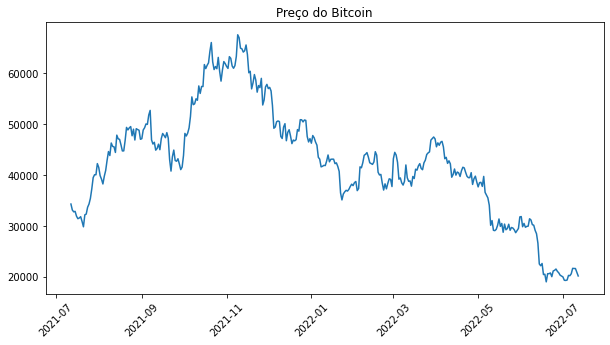

In [ ]:
fig = plt.figure() 
fig.set_size_inches(10, 5)
plt.title('Preço do Bitcoin')
plt.plot(df_bitcoin['Close time'], df_bitcoin['Close BTC'])
plt.xticks(rotation=45)
plt.show()    

### **Gráfico de preço da Dogecoin**

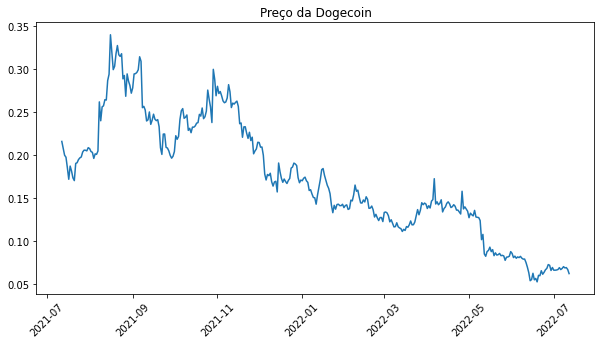

In [ ]:
fig = plt.figure() 
fig.set_size_inches(10, 5)
plt.title('Preço da Dogecoin')
plt.plot(df_dogecoin['Close time'], df_dogecoin['Close'])
plt.xticks(rotation=45)
plt.show()    

### **Existiu correlação entre os preços de fechamento diários das criptomoedas?**

**Matriz de correlação entre o fechamento diário dos preços durante 1 ano**

In [ ]:
tabela_moedas = pd.concat([df_bitcoin, df_dogecoin], axis = 1)
tabela_moedas = tabela_moedas[['Close BTC', 'Close']]

corr = tabela_moedas.corr()
corr.style.background_gradient(cmap='coolwarm')

,Close BTC,Close
Close BTC,1.000000,0.797847
Close,0.797847,1.000000


**Gráfico da mudança relativa no fechamento dos preços durante 1 ano**

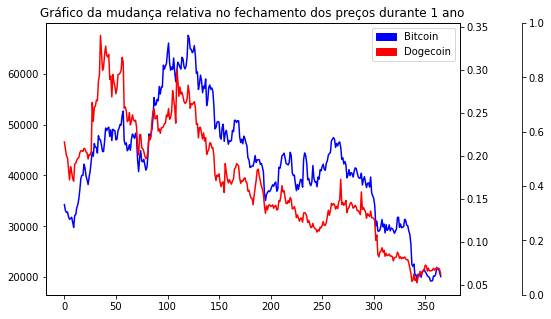

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
rspine = ax2.spines['right']
rspine.set_position(('axes', 1.15))
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
plt.title('Gráfico da mudança relativa no fechamento dos preços durante 1 ano')
fig.subplots_adjust(right = 0.7)

red_patch = mpatches.Patch(color='red', label='Dogecoin')
blue_patch = mpatches.Patch(color='blue', label='Bitcoin')
plt.legend(loc="upper right", handles=[blue_patch, red_patch])

df_bitcoin['Close BTC'].plot(ax=ax1, style='b-')
df_dogecoin['Close'].plot(ax=ax1, style='r-', secondary_y=True)

### **Qual foi a maior alta e baixa das criptomoedas no ano de análise?**

In [ ]:
max_bitcoin = df_bitcoin['High'].max()
min_bitcoin = df_bitcoin['Low'].min()
id_max = df_bitcoin['High'].idxmax()
id_min = df_bitcoin['Low'].idxmin()
print('O preço máximo do bitcoin neste ano foi: {} durante {}'.format(max_bitcoin, df_bitcoin['Open time'].iloc[id_max]))
print('O preço mínimo do bitcoin neste ano foi: {} durante {}'.format(min_bitcoin, df_bitcoin['Open time'].iloc[id_min]))

O preço máximo do bitcoin neste ano foi: 69000.0 durante 2021-11-10 00:00:00
O preço mínimo do bitcoin neste ano foi: 17622.0 durante 2022-06-18 00:00:00


In [ ]:
max_dogecoin = df_dogecoin['High'].max()
min_dogecoin = df_dogecoin['Low'].min()
id_max = df_dogecoin['High'].idxmax()
id_min = df_dogecoin['Low'].idxmin()
print('O preço máximo do doge coin neste ano foi: {} durante {}'.format(max_dogecoin, df_dogecoin['Open time'].iloc[id_max]))
print('O preço mínimo do doge coin neste ano foi: {} durante {}'.format(min_dogecoin, df_dogecoin['Open time'].iloc[id_min]))

O preço máximo do doge coin neste ano foi: 0.3517 durante 2021-08-16 00:00:00
O preço mínimo do doge coin neste ano foi: 0.04914 durante 2022-06-18 00:00:00


### **Utilizando o índice de força relativa, quais foram os 10 melhores pontos de compra no ano dessas duas criptomoedas?**

**Bitcoin**

In [ ]:
df_bitcoin['Gain'] = (df_bitcoin['Close BTC'] - df_bitcoin['Open']).apply(lambda x : x if x > 0 else 0)
df_bitcoin['Loss'] = (df_bitcoin['Close BTC'] - df_bitcoin['Open']).apply(lambda x : x if x < 0 else 0)

In [ ]:
df_bitcoin['Ema gain'] = df_bitcoin['Gain'].ewm(span = 7, min_periods = 7).mean()
df_bitcoin['Ema loss'] = df_bitcoin['Loss'].ewm(span = 7, min_periods = 7).mean()

In [ ]:
df_bitcoin['RS'] = df_bitcoin['Ema gain']  / df_bitcoin['Ema loss']

In [ ]:
df_bitcoin['RSI_14'] = 100 - (100/(df_bitcoin['RS']+1))

In [ ]:
data = df_bitcoin['RSI_14']

In [ ]:
dif = max(data.dropna()) - min(data.dropna())
minimo = min(data.dropna())

In [ ]:
data_new_btc = []
for elem in data:
  elem = (elem - minimo)/ dif
  data_new_btc.append(elem*100)

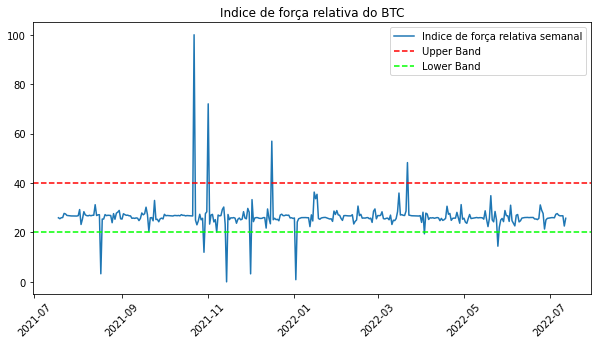

In [ ]:
fig = plt.figure() 
fig.set_size_inches(10, 5)
plt.title('Indice de força relativa do BTC')
plt.plot(df_bitcoin['Close time'], data_new_btc, label="Indice de força relativa semanal")
plt.xticks(rotation=45)
plt.axhline(y = 40, color='red', linestyle = 'dashed', label="Upper Band")
plt.axhline(y = 20, color='lime', linestyle = 'dashed', label="Lower Band")
plt.legend(loc="upper right")
plt.show()    

**Dogecoin**

In [ ]:
df_dogecoin['Gain'] = (df_dogecoin['Close'] - df_dogecoin['Open']).apply(lambda x : x if x > 0 else 0)
df_dogecoin['Loss'] = (df_dogecoin['Close'] - df_dogecoin['Open']).apply(lambda x : x if x < 0 else 0)

In [ ]:
df_dogecoin['Ema gain'] = df_dogecoin['Gain'].ewm(span = 7, min_periods = 7).mean()
df_dogecoin['Ema loss'] = df_dogecoin['Loss'].ewm(span = 7, min_periods = 7).mean()

In [ ]:
df_dogecoin['RS'] = df_dogecoin['Ema gain']  / df_dogecoin['Ema loss']

In [ ]:
df_dogecoin['RSI_14'] = 100 - (100/(df_dogecoin['RS']+1))

In [ ]:
data = df_dogecoin['RSI_14']

In [ ]:
dif = max(data.dropna()) - min(data.dropna())
minimo = min(data.dropna())

In [ ]:
data_new = []
for elem in data:
  elem = (elem - minimo)/ dif
  data_new.append(elem*100)

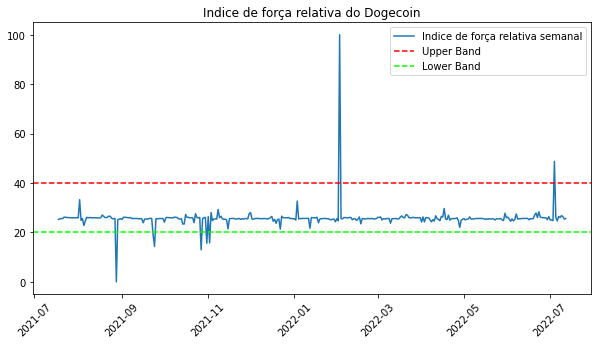

In [ ]:
fig = plt.figure() 
fig.set_size_inches(10, 5)
plt.title('Indice de força relativa do Dogecoin')
plt.plot(df_dogecoin['Close time'], data_new, label="Indice de força relativa semanal")
plt.xticks(rotation=45)
plt.axhline(y = 40, color='red', linestyle = 'dashed', label="Upper Band")
plt.axhline(y = 20, color='lime', linestyle = 'dashed', label="Lower Band")
plt.legend(loc="upper right")
plt.show()    

### **O gráfico de preço da Dogecoin apresentou uma tendência de crescimento maior que a do Bitcoin?**

**Tendência do Bitcoin**

In [ ]:
media_movel = df_bitcoin['Close BTC'].rolling(window = 7)

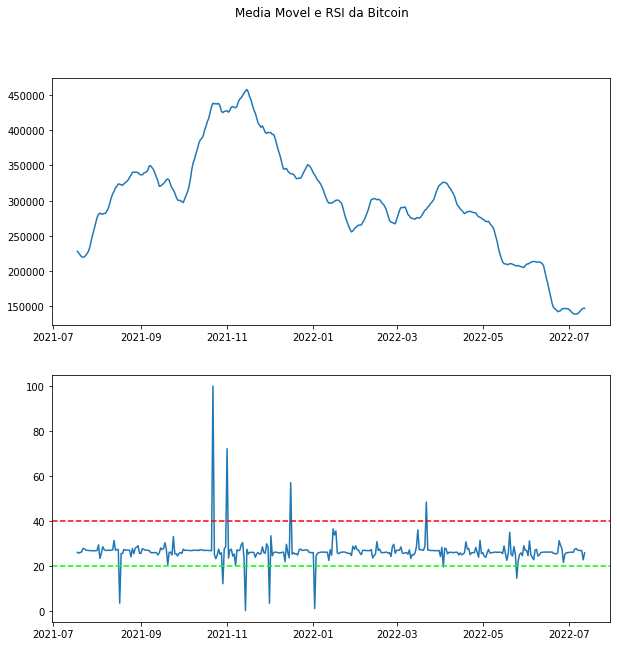

In [ ]:
fig, media = plt.subplots(2)
fig.set_size_inches(10, 10)
fig.suptitle('Media Movel e RSI da Bitcoin')
media[0].plot(df_bitcoin['Close time'], media_movel.sum())
media[1].plot(df_bitcoin['Close time'], data_new_btc)
media[1].axhline(y = 20, color='lime', linestyle ='dashed')
media[1].axhline(y = 40, color='red', linestyle ='dashed')
plt.show()    

**Tendência da Dogecoin**

In [ ]:
media_movel_doge = df_dogecoin['Close'].rolling(window = 7)

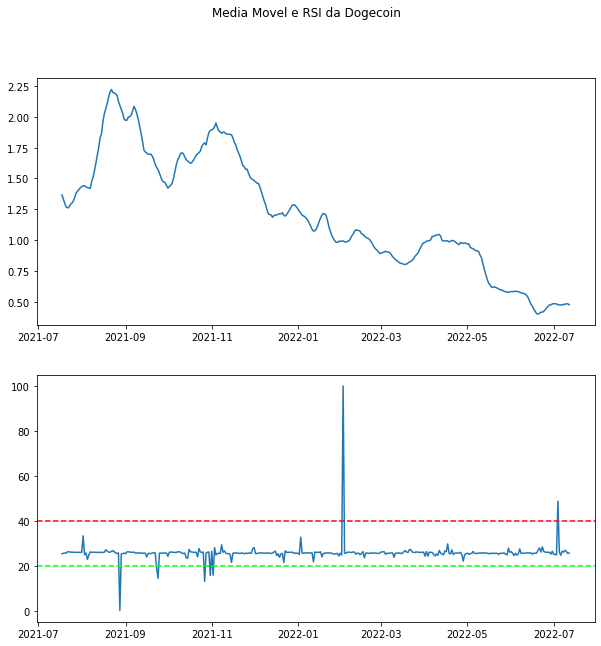

In [ ]:
fig, media = plt.subplots(2)
fig.set_size_inches(10, 10)
fig.suptitle('Media Movel e RSI da Dogecoin')
media[0].plot(df_dogecoin['Close time'], media_movel_doge.sum())
media[1].plot(df_dogecoin['Close time'], data_new)
media[1].axhline(y = 20, color='lime', linestyle ='dashed')
media[1].axhline(y = 40, color='red', linestyle ='dashed')
plt.show()

### **Boxplot dos preços das criptomoedas**

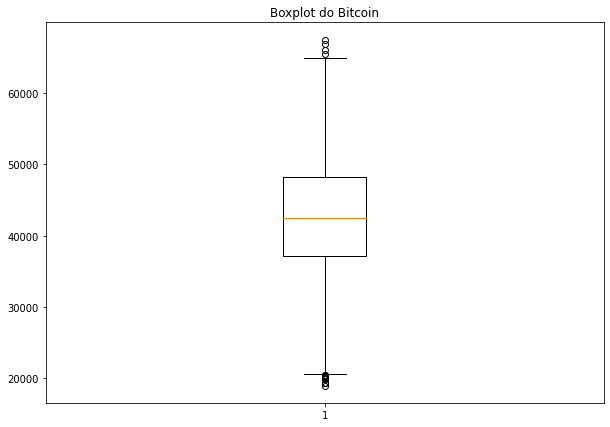

In [ ]:
fig = plt.figure(figsize =(10, 7))
plt.title('Boxplot do Bitcoin')
plt.boxplot(df_bitcoin['Close BTC'])
plt.show()

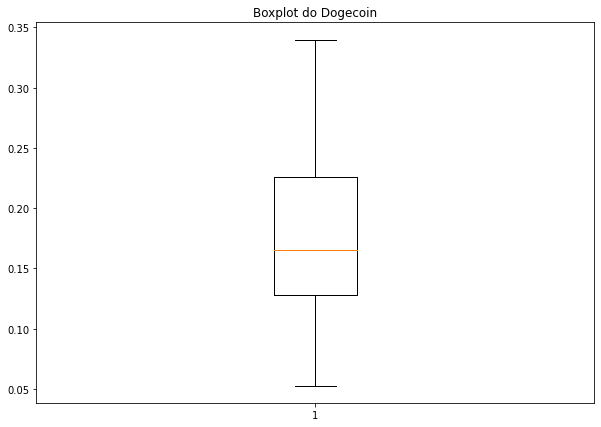

In [ ]:
fig = plt.figure(figsize =(10, 7))
plt.title('Boxplot do Dogecoin')
plt.boxplot(df_dogecoin['Close'])
plt.show()

### **Fear/Greed Index**

**Link de onde retiramos esses dados:** https://production.dataviz.cnn.io/index/fearandgreed/graphdata

In [ ]:
f = open('/content/graphdata.json')
data = json.load(f)
f.close()

In [ ]:
fear_greed_index = pd.DataFrame(data['fear_and_greed_historical']['data'])
fear_greed_index['x'] = pd.to_datetime(fear_greed_index['x']//1000, unit='s').dt.strftime('%Y-%m-%d')
fear_greed_index = fear_greed_index.rename(columns={'x':'date','y':'fear_metric'})

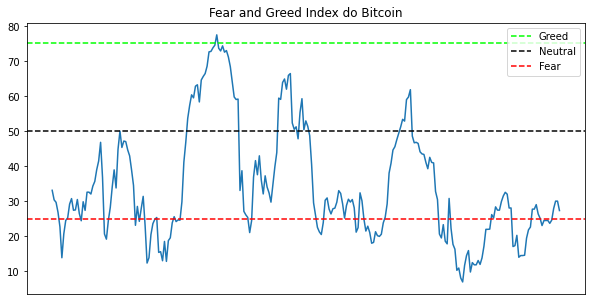

In [ ]:
fig = plt.figure() 
ax = plt.gca()
fig.set_size_inches(10, 5)
plt.title('Fear and Greed Index do Bitcoin')
plt.plot(fear_greed_index['date'], fear_greed_index['fear_metric'])
plt.axhline(y = 75, color='lime', linestyle = 'dashed', label="Greed")
plt.axhline(y = 50, color='black', linestyle = 'dashed', label="Neutral")
plt.axhline(y = 25, color='red', linestyle = 'dashed', label="Fear")
plt.legend(loc="upper right")
plt.xticks(rotation=45)
ax.axes.xaxis.set_visible(False)
plt.show()    

# **3) Pré-processamento dos dados**

* **Remoção de colunas irrelevantes para o modelo que apenas foram criadas para a plotagem dos gráficos para responder às perguntas anteriores**

* **Fora identificado que o dataframe não possui valores nulos, outliers (que afetem no aprendizado do modelo) ou inconsistentes**

In [ ]:
df_bitcoin.drop(columns = {'RSI_14', 'RS', 'Gain', 'Loss', 'Ema gain', 'Ema loss'}, axis=1, inplace=True)
df_dogecoin.drop(columns = {'RSI_14', 'RS', 'Gain', 'Loss', 'Ema gain', 'Ema loss'}, axis=1, inplace=True)

In [ ]:
df_bitcoin.isna().sum()

Open time                       0
Open                            0
High                            0
Low                             0
Close BTC                       0
Volume                          0
Close time                      0
Quote asset volume              0
Number of trades                0
Taker buy base asset volume     0
Taker buy quote asset volume    0
dtype: int64

In [ ]:
df_dogecoin.isna().sum()

Open time                       0
Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
Close time                      0
Quote asset volume              0
Number of trades                0
Taker buy base asset volume     0
Taker buy quote asset volume    0
dtype: int64

# **4) Modelagem e Avaliação do Trading Bot**

> **Para essa fase, usamos o algoritmo de machine learning criado pela equipe do Facebook, Prophet, o motivo pelo qual nós decidimos escolher esse modelo em específico é porque ele se sai muito bem com séries temporais afetadas pela sazonalidade, que é o caso das criptomoedas**
* **Separação do dataframe em treino e validação**
* **Treinamento do modelo**
* **Avaliação do modelo com R2 Score**

## **Modelo Bitcoin**

In [ ]:
x_train_btc = df_bitcoin[0:356]
y_true_btc = df_bitcoin['Close BTC'][-10:]

In [ ]:
df_mini_btc = x_train_btc[['Close time', 'Close BTC']].copy()

In [ ]:
df_mini_btc.rename(columns = {'Close time': 'ds', 'Close BTC':'y'}, inplace = 'True')

In [ ]:
prophet_btc = Prophet()
prophet_btc.fit(df_mini_btc)

In [ ]:
future_btc = prophet_btc.make_future_dataframe(periods=14)
forecast_btc = prophet_btc.predict(future_btc)

In [ ]:
forecast_btc[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2022-07-11 23:59:59.999,18008.051910,13513.222534,22439.353533
366,2022-07-12 23:59:59.999,17685.121952,13307.733265,22274.206749
367,2022-07-13 23:59:59.999,17599.244563,13397.455582,21969.787212
368,2022-07-14 23:59:59.999,17008.667993,12669.907563,21429.492806
369,2022-07-15 23:59:59.999,16752.229150,12293.277270,21255.328161


### **Avaliação e resultado do modelo**

Text(0.5, 1.0, 'Gráfico de predição do preço de fechamento do Bitcoin')

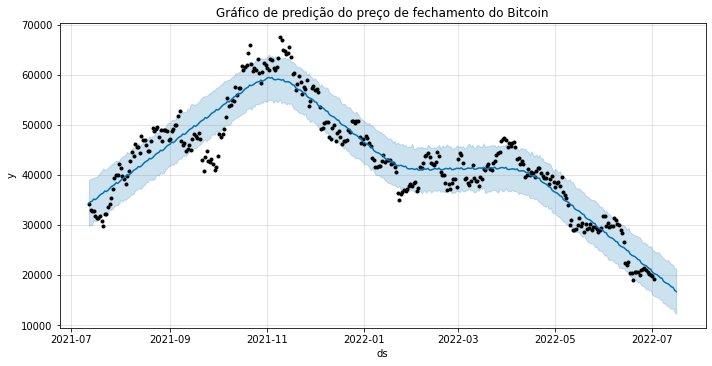

In [ ]:
prophet_btc.plot(forecast_btc, figsize=(10, 5))
plt.title('Gráfico de predição do preço de fechamento do Bitcoin')

**Validação do Modelo**

In [ ]:
y_pred_val = forecast_btc['yhat'][-14:]
y_pred_val = y_pred_val[0:10]

In [ ]:
score = r2_score(y_true_btc, y_pred_val)
print("A pontuação r2 do modelo é de {}".format(score))

A pontuação r2 do modelo é de -4.924863043604675


In [ ]:
y_true_btc

356    19252.81
357    19315.83
358    20236.71
359    20175.83
360    20564.51
361    21624.98
362    21594.75
363    21591.83
364    20862.47
365    20128.36
Name: Close BTC, dtype: float64

In [ ]:
y_pred_val

356    20227.791218
357    20101.579378
358    19823.021974
359    19500.092017
360    19414.214628
361    18823.638058
362    18567.199215
363    18412.821154
364    18286.609314
365    18008.051910
Name: yhat, dtype: float64

**Teste do Modelo**



In [ ]:
forecast_btc['yhat'][-4:]

366    17685.121952
367    17599.244563
368    17008.667993
369    16752.229150
Name: yhat, dtype: float64

## **Modelo Dogecoin**

In [ ]:
x_train_doge = df_dogecoin[0:356]
y_true_doge = df_dogecoin['Close'][-10:]

In [ ]:
df_mini_doge = x_train_doge[['Close time', 'Close']].copy()

In [ ]:
df_mini_doge.rename(columns = {'Close time': 'ds', 'Close':'y'}, inplace = 'True')

In [ ]:
prophet = Prophet()
prophet.fit(df_mini_doge)

In [ ]:
future = prophet.make_future_dataframe(periods=14)
forecast = prophet.predict(future)

In [ ]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2022-07-11 23:59:59.999,0.060269,0.030375,0.091377
366,2022-07-12 23:59:59.999,0.058214,0.025812,0.091264
367,2022-07-13 23:59:59.999,0.057756,0.026301,0.088247
368,2022-07-14 23:59:59.999,0.056545,0.022143,0.090415
369,2022-07-15 23:59:59.999,0.056340,0.025205,0.089560


### **Avaliação e resultado do modelo**

Text(0.5, 1.0, 'Gráfico de predição do preço de fechamento do Dogecoin')

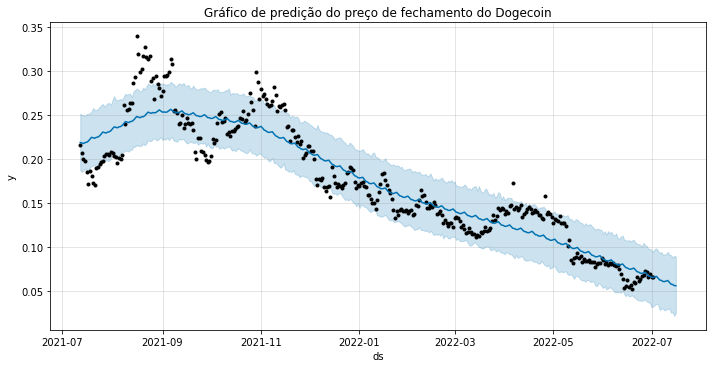

In [ ]:
prophet.plot(forecast, figsize=(10, 5))
plt.title('Gráfico de predição do preço de fechamento do Dogecoin')

**Validação do Modelo**

In [ ]:
y_pred_doge = forecast['yhat'][-14:]
y_pred_doge = y_pred_doge[0:10]

In [ ]:
score = r2_score(y_true_doge, y_pred_doge)
print("A pontuação r2 do modelo é de {}".format(score))

A pontuação r2 do modelo é de -5.948739514918204


In [ ]:
y_true_doge

356    0.06667
357    0.06721
358    0.06938
359    0.06716
360    0.06844
361    0.07055
362    0.06906
363    0.06947
364    0.06728
365    0.06248
Name: Close, dtype: float64

In [ ]:
y_pred_doge

356    0.066325
357    0.067002
358    0.064963
359    0.062909
360    0.062451
361    0.061239
362    0.061035
363    0.061631
364    0.062308
365    0.060269
Name: yhat, dtype: float64

**Teste do Modelo**

In [ ]:
forecast['yhat'][-4:]

366    0.058214
367    0.057756
368    0.056545
369    0.056340
Name: yhat, dtype: float64